### Проект e-commerce
**Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:**

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. 
6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. 

**Файлы:**

 *olist_customers_datase.csv* — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

- customer_unique_id —  уникальный идентификатор пользователя

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

*olist_orders_dataset.csv* —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

*olist_order_items_dataset.csv*—  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице *olist_order_items_dataset*:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Прочитаем первый датасет и посмотрим, что он из себя представляет
customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [5]:
customers.shape

(99441, 5)

In [6]:
# Прочитаем второй датасет и посмотрим на его характеристики
orders = pd.read_csv('olist_orders_dataset.csv')

In [10]:
# Посмотрим, в каком диапазоне дат лежат имеющиеся данные
orders.sort_values('order_purchase_timestamp').order_purchase_timestamp.min()

'2016-09-04 21:15:19'

In [11]:
orders.sort_values('order_purchase_timestamp').order_purchase_timestamp.max()

'2018-10-17 17:30:18'

In [99]:
orders.shape

(99441, 8)

In [100]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Несмотря на то, что в некоторых столбцах указаны даты, python считал все как строковый тип. Переведем все столбцы с датами в datetime, наверняка это окажется полезным в дальнейшей работе с данными

In [12]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d')

In [13]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [16]:
# Посмотрим, какие вообще есть статусы у заказов
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [17]:
# Загрузим третий датасет и посмотрим, какая информация содержится в нем
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [18]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
order_items.shape

(112650, 7)

In [20]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [21]:
# В этом датасете также есть столбец с датой, который приведем к формату datetime
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

**1. Сколько у нас пользователей, которые совершили покупку только один раз?**

In [22]:
# Возьмем столбец customer_id в качестве ключа для объединения двух датасетов - с информацией о пользователях
# и с информацией о заказах
customers_n_orders = customers.merge(orders, on='customer_id')

In [23]:
customers_n_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [26]:
customers_n_orders.shape

(99441, 12)

In [27]:
# Посмотрим на пропущенные значения в датафрейме
customers_n_orders.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Пропущенные значения есть только для столбцов, в которых указано время оплаты/доставки заказа. Очевидно, это связано с тем, что не все заказы были оплачены (для 160 нет подтверждения оплаты заказа), не все переданы в службу доставки (таких уже значительно больше, 1783, это может быть связано с тем, что заказ отменили уже после оплаты), и еще больше заказов (2965) не были доставлены до покупателей. Возможно, покупатели отменили заказы уже после передачи в службу доставки. Также есть вероятность того, что у нас просто неполные данные, что они по каким-то причинам не были внесены в базу.

Можно по-разному трактовать, что именно считать совершенной покупкой. Мне кажется верным считать совершенной покупкой те заказы, которые были оплачены. Возможно, покупатель потом заказ отменит или произойдет что-то другое, но покупку (факт передачи денег за товар) он уже совершил. В столбце order_approved_at указано время, когда была произведена оплата товара. Для подсчета числа заказов возьмем только те строки датасета, где это время указано.

In [28]:
# создадим столбец, в котором будет указано, проходила оплата или нет
customers_n_orders['no_paid'] = customers_n_orders.order_approved_at.isna()

In [29]:
customers_with_one_order = customers_n_orders \
                        .query('no_paid == False') \
                        .groupby('customer_unique_id') \
                        .agg({'order_id': 'count'}) \
                        .query('order_id == 1')
# сгруппируем данные по уникальному id пользователя и посчитаем количество заказов для каждого уникального пользователя
# оставим только тех пользователей, которые сделали ровно 1 заказ

In [30]:
customers_with_one_order.shape[0]

93049

**Таких пользователей оказалось 93049**

Возможно, бизнес интересуют только те покупатели, заказы которым были доставлены. В таком случае, для анализа возьмем те заказы, которые имеют статус delivered:

In [31]:
customers_with_one_order_2 = customers_n_orders \
                            .query('order_status == "delivered"') \
                            .groupby('customer_unique_id') \
                            .agg({'order_id': 'count'}) \
                            .query('order_id == 1')

In [32]:
customers_with_one_order_2.shape[0]

90557

**В данном случае количество покупателей, совершивших одну покупку, 90557.** Это количество меньше предыдущего за счет того, что в данном случае мы считаем покупателями не всех, кто проводил оплату, а только тех, кто в итоге забрал свою покупку.

**2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

In [33]:
# выведем те заказы, у которых в графе order_delivered_customer_date стоит пропуск
no_delivered = customers_n_orders[customers_n_orders.order_delivered_customer_date.isna() == True]

In [34]:
# посмотрим, за какой временной промежуток вообще есть данные
no_delivered.sort_values('order_purchase_timestamp')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,no_paid
84697,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,False
70561,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,False
84845,622e13439d6b5a0b486c435618b2679e,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,False
90294,b106b360fe2ef8849fbbd056f777b4d5,0eb1ee9dba87f5b36b4613a65074337c,2975,sao paulo,SP,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,False
59932,e81a9f176936e3124dfd90c483bf3289,823c47d4abda1f8ce7568145f76c2b85,13175,sumare,SP,1aecadf4362edaca7fa033e882076c8d,canceled,2016-10-04 10:05:45,2016-10-04 10:26:40,NaT,NaT,2016-11-24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75985,2823ffda607a2316375088e0d00005ec,9bb92bebd4cb7511e1a02d5e50bc4655,7176,guarulhos,SP,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15,True
75902,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23,True
68312,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,registro,SP,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16,True
69139,856336203359aa6a61bf3826f7d84c49,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12,True


Данные есть с сентября 2016-го по октябрь 2018-го; эти месяцы будем брать для подсчета средних.

In [35]:
# посмотрим, какие статусы имеют заказы, которые не были доставлены покупателям
no_delivered.groupby('order_status').agg({'order_id': 'count'})

,order_id
order_status,
approved,2
canceled,619
created,5
delivered,8
invoiced,314
processing,301
shipped,1107
unavailable,609


Очевидно, не все статусы стоит рассматривать как те, которые не доставлены. О некоторых из них мы еще ничего не можем сказать, 
так как заказы еще не успели отправиться к покупателям. Возьмем для расчетов заказы со статусами canceled и unavailable - эти два статуса будем считать причинами того, что заказы не были доставлены

In [36]:
# для заказов, которые были отменены (canceled):
canceled_by_month = no_delivered \
        .query('order_status == "canceled"') \
        .groupby([no_delivered.order_purchase_timestamp.dt.year, no_delivered.order_purchase_timestamp.dt.month]) \
        .agg({'order_id': 'count'})
canceled_by_month

order_id
order_purchase_timestamp order_purchase_timestamp          
2016                     9                                2
                         10                              19
2017                     1                                3
                         2                               17
                         3                               33
                         4                               18
                         5                               29
                         6                               16
                         7                               28
                         8                               27
                         9                               20
                         10                              26
                         11                              37
                         12                              11
2018                     1                               34
                         2                               72
                         3                               26
                         4                               15
                         5                               24
                         6                               18
                         7                               41
                         8                               84
                         9                               15
                         10                               4

Из получившегося датасета видим, что не все месяцы указаны. Изучив данные, видим, что для ноября и декабря данные отсутствуют вообще, поэтому их брать в расчет не будем

In [37]:
# теперь вычислим среднее количество отмененных заказов в месяц
canceled_by_month.order_id.mean()

25.791666666666668

Теперь посчитаем среднее количество заказов в месяц, имеющих статус unavailable

In [38]:
unavailable_by_month = no_delivered \
        .query('order_status == "unavailable"') \
        .groupby([no_delivered.order_purchase_timestamp.dt.year, no_delivered.order_purchase_timestamp.dt.month]) \
        .agg({'order_id': 'count'})
unavailable_by_month

order_id
order_purchase_timestamp order_purchase_timestamp          
2016                     10                               7
2017                     1                               10
                         2                               45
                         3                               32
                         4                                9
                         5                               31
                         6                               24
                         7                               52
                         8                               32
                         9                               38
                         10                              58
                         11                              84
                         12                              42
2018                     1                               48
                         2                               30
                         3                               17
                         4                                5
                         5                               16
                         6                                4
                         7                               18
                         8                                7

В этом датасете отсутствуют также данные за сентябрь 2016, сентябрь и октябрь 2018, хотя такие периоды в исходном датасете есть. Посчитаем, что в это время заказов с таким статусом не было, поэтому учтем этот факт при расчете среднего

In [39]:
# посчитаем среднее значение, добавив три нулевых значения 
unavailable_by_month.order_id.sum() / (unavailable_by_month.shape[0] + 3)

25.375

**Таким образом, в среднем в месяц не доставляется до покупателя 25.8 заказов по причине их отмены и 25.375 заказов по причине недоступности заказа**

**3. По каждому товару определить, в какой день недели товар чаще всего покупается.**

In [40]:
# сначала соберем новый датасет, в котором объединится информация о датах покупок и об id товаров
orders_n_items = orders.merge(order_items, on='order_id')

In [41]:
# добавим новый столбец с указанием дней недели
orders_n_items['day_of_week'] = orders_n_items.order_purchase_timestamp.dt.day_name()

In [42]:
orders_n_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [43]:
# теперь выделим для каждого из товаров тот день недели, в который заказов было больше всего
products_on_day = orders_n_items \
                    .groupby(['product_id', 'day_of_week'], as_index=False) \
                    .agg({'order_id': 'count'}) \
                    .sort_values(['product_id', 'order_id'], ascending=[False, False]) \
                    .groupby('product_id') \
                    .head(1) \
                    .rename(columns={'order_id': 'number_of_orders'})
products_on_day

,product_id,day_of_week,number_of_orders
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
61224,fff9553ac224cec9d15d49f5a263411f,Friday,1
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
61221,fff6177642830a9a94a0f2cba5e476d1,Saturday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


Получили таблицу, в которой для каждого из товаров указан день недели, в который было совершено наибольшее число покупок, а также это число покупок.

**4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)**

In [44]:
# соберем нужный для расчетов датасет
full_df = customers_n_orders.merge(order_items, on='order_id')
full_df = full_df \
        .loc[:, ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'product_id']]
full_df

,customer_unique_id,order_id,order_purchase_timestamp,product_id
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,a9516a079e37a9c9c36b9b78b10169e8
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,4aa6014eceb682077f9dc4bffebc05b0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,bd07b66896d6f1494f5b86251848ced7
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,a5647c44af977b148e0a3a4751a09e2e
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,9391a573abe00141c56e38d84d7d5b3b
...,...,...,...,...
112645,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,ccb4503d9d43d245d3b295d0544f988b
112646,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,9ede6b0570a75a4b9de4f383329f99ee
112647,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,7a5d2e1e131a860ae7d18f6fffa9d689
112648,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,f819f0c84a64f02d3a5606ca95edd272


In [45]:
# выделим из даты покупки год, месяц и количество недель в месяце
full_df['year'] = full_df.order_purchase_timestamp.dt.year
full_df['month'] = full_df.order_purchase_timestamp.dt.month_name()
full_df['day_in_month'] = full_df.order_purchase_timestamp.dt.daysinmonth

In [46]:
# добавим столбец с количеством недель в месяце
full_df['mean_weeks'] = full_df.day_in_month / 7
full_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,product_id,year,month,day_in_month,mean_weeks
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,a9516a079e37a9c9c36b9b78b10169e8,2017,May,31,4.428571
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,4aa6014eceb682077f9dc4bffebc05b0,2018,January,31,4.428571
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,bd07b66896d6f1494f5b86251848ced7,2018,May,31,4.428571
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,a5647c44af977b148e0a3a4751a09e2e,2018,March,31,4.428571
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,9391a573abe00141c56e38d84d7d5b3b,2018,July,31,4.428571


In [47]:
# для каждого уникального пользователя посчитаем число покупок с разбивкой по месяцам 
grouped_df = full_df \
                .groupby(['customer_unique_id', 'year', 'month']) \
                .agg({'product_id': 'nunique',
                      'mean_weeks': 'sum'}) \
                .rename(columns={'product_id': 'number_of_unique_products'})
grouped_df.mean_weeks = grouped_df.mean_weeks / grouped_df.number_of_unique_products
grouped_df

,,,number_of_unique_products,mean_weeks
customer_unique_id,year,month,,
0000366f3b9a7992bf8c76cfdf3221e2,2018,May,1,4.428571
0000b849f77a49e4a4ce2b2a4ca5be3f,2018,May,1,4.428571
0000f46a3911fa3c0805444483337064,2017,March,1,4.428571
0000f6ccb0745a6a4b88665a16c9f078,2017,October,1,4.428571
0004aac84e0df4da2b147fca70cf8255,2017,November,1,4.285714
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017,June,2,4.285714
fffea47cd6d3cc0a88bd621562a9d061,2017,December,1,4.428571
ffff371b4d645b6ecea244b27531430a,2017,February,1,4.000000


In [48]:
# Добавим столбец с информацией о среднем количестве покупок в неделю по месяцам
grouped_df['purchases_per_week'] = grouped_df.number_of_unique_products / grouped_df.mean_weeks
grouped_df.head()

,,,number_of_unique_products,mean_weeks,purchases_per_week
customer_unique_id,year,month,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018,May,1,4.428571,0.225806
0000b849f77a49e4a4ce2b2a4ca5be3f,2018,May,1,4.428571,0.225806
0000f46a3911fa3c0805444483337064,2017,March,1,4.428571,0.225806
0000f6ccb0745a6a4b88665a16c9f078,2017,October,1,4.428571,0.225806
0004aac84e0df4da2b147fca70cf8255,2017,November,1,4.285714,0.233333


В получившемся датасете можно увидеть информацию о среднем числе покупок в неделю для каждого из пользователей

**5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.**

Здесь нам понадобится датасет с информацией о покупателях и заказах. Поэтому воспользуемся тем, который уже создавали

In [49]:
customers_n_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,no_paid
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,False
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,False
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,False
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,False


In [50]:
# из этого датасета оставим только те столбцы, которые нам понадобятся
cohort_df = customers_n_orders[['customer_unique_id', 'order_purchase_timestamp']].drop_duplicates()

In [51]:
cohort_df.head()

,customer_unique_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30


In [52]:
# от времени заказа для анализа нам нужны месяц и год, оставим только их
# и получим когорты, сгруппировав заказы по уникальным пользователям, выделив первые заказы и также отбросив все, кроме месяца и года
cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')
cohort_df['cohort'] = cohort_df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                                 .transform('min') \
                                 .dt.to_period('M')

In [53]:
cohort_df.head()

,customer_unique_id,order_purchase_timestamp,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07,2018-07


In [54]:
# все когорты
cohort_df.cohort.unique()

<PeriodArray>
['2017-05', '2018-01', '2018-05', '2018-03', '2018-07', '2017-09', '2018-02',
 '2017-11', '2018-04', '2018-08', '2018-06', '2017-08', '2017-10', '2017-04',
 '2017-06', '2017-12', '2017-01', '2017-07', '2017-03', '2017-02', '2016-10',
 '2018-09', '2016-12', '2016-09', '2018-10']
Length: 25, dtype: period[M]

In [55]:
# теперь сгруппируем по когортам и дате заказа, подсчитав число уникальных покупателей для каждой когорты
cohort_df_2 = cohort_df.groupby(['cohort', 'order_month']) \
                          .agg(number_of_customers=('customer_unique_id', 'nunique')) \
                          .reset_index(drop=False)


In [56]:
# и добавим новый столбец с периодами, на которые будем разбивать исследование. 
# в периоде будет занесена разница между месяцем когорты и месяцем заказа
cohort_df_2['period_number'] = (cohort_df_2.order_month - cohort_df_2.cohort).apply(attrgetter('n'))


In [57]:
cohort_df_2.head()

,cohort,order_month,number_of_customers,period_number
0,2016-09,2016-09,4,0
1,2016-10,2016-10,321,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


In [58]:
cohort_df_2.tail()

,cohort,order_month,number_of_customers,period_number
220,2018-08,2018-08,6271,0
221,2018-08,2018-09,7,1
222,2018-08,2018-10,2,2
223,2018-09,2018-09,5,0
224,2018-10,2018-10,1,0


In [59]:
# из получившегося датасета соберем сводную таблицу
pivot_cohort = cohort_df_2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'number_of_customers')
pivot_cohort

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [60]:
# выделим в отдельную переменную размеры когорт, они нам понадобятся для расчета retention для каждого из пользователей
cohort_size = pivot_cohort.iloc[:,0]
# и посчитаем retention, поделив значения в сводной таблице на размер когорты (все пользователи, которые сделали заказ в данный месяц)
# результат выведем в процентах
retention_matrix = pivot_cohort.divide(cohort_size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


In [61]:
# Теперь визуализируем retention
ur_style = (retention_matrix
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='BrBG')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


**Как легко можно увидеть из визуализации, периодом с января по декабрь с самым высоким retention на третий месяц является июнь (retention = 0.41%)**

Теперь автоматизируем вычисления, записав все в виде функции, на вход которой подается датасет, в котором есть обязательные столбцы 
customer_unique_id и order_purchase_timestamp

In [62]:
def make_cohorts(df):
    cohort_df = df[['customer_unique_id', 'order_purchase_timestamp']].drop_duplicates()
    cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')
    cohort_df['cohort'] = cohort_df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                                 .transform('min') \
                                 .dt.to_period('M')
    cohort_df_2 = cohort_df.groupby(['cohort', 'order_month']) \
                          .agg(number_of_customers=('customer_unique_id', 'nunique')) \
                          .reset_index(drop=False)
    cohort_df_2['period_number'] = (cohort_df_2.order_month - cohort_df_2.cohort).apply(attrgetter('n'))
    pivot_cohort = cohort_df_2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'number_of_customers')
    cohort_size = pivot_cohort.iloc[:,0]
    retention_matrix = pivot_cohort.divide(cohort_size, axis = 0)
    
    return retention_matrix
    ur_style = (retention_matrix
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='BrBG')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    return ur_style
  

In [148]:
make_cohorts(customers_n_orders)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


**6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).**

Для разбиения на кластеры воспользуемся библиотекой RFMizer, для этого подготовим необходоимые данные:

In [63]:
# Создадим общий датасет из трех:
df = customers_n_orders.merge(order_items, on='order_id') \
                .loc[:, ['order_purchase_timestamp', 'customer_unique_id', 'price']]
# Приведем к временному формату дату совершения заказа
df.order_purchase_timestamp = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S') \
                                .dt.to_period('d')
# Переименуем колонки, чтобы воспользоваться библиотекой
df.rename(columns={'order_purchase_timestamp': 'order_date',
                   'customer_unique_id': 'user_id',
                   'price': 'order_value'}, inplace=True)
# И отсортируем заказы по дате 
df.sort_values('order_date', inplace=True)
df.tail()


,order_date,user_id,order_value
56513,2018-08-29,b701bebbdf478f5500348f03aff62121,24.90
54924,2018-08-29,0c6d7218d5f3fa14514fd29865269993,169.80
70726,2018-08-29,7a22d14aa3c3599238509ddca4b93b01,63.90
101786,2018-08-29,afbcfd0b9c5233e7ccc73428526fbb52,91.55
75052,2018-09-03,ff22e30958c13ffe219db7d711e8f564,145.00


In [64]:
df.dtypes

order_date     period[D]
user_id           object
order_value      float64
dtype: object

In [151]:
df.to_csv('orders.csv', index=False)

Получившийся файл загрузили в библиотеку RFMizer, на выходе получили разбивку на кластеры по каждой из трех метрик. Я выбрала разбивку на три кластера для каждой из метрик. Это показалось мне подходящим для нашей ситуации, потому как в основном пользователи однотипные - это пользователи с единичой покупкой (93049 из 99441 записей в датасете). И даже разбиение на большее количество кластеров по метрике monetary мне не кажется обоснованным, потому как RFM анализ нацелен на создание более индивидуального подхода для каждого из сегментов, а если пользователи как правило не возвращаются за второй покупкой, то вряд ли есть смысл создавать такие малочисленные группы. 

In [66]:
# прочитаем получившийся файл с разбивкой на кластеры
mapping = pd.read_csv('rfm_mapping.csv')
mapping.head()

,customer_unique_id,frequency,monetary,recency
0,b7d76e111c89f7ebf14761390f0f7d17,1,2,1
1,4854e9b3feff728c13ee5fc7d1547e92,1,2,1
2,830d5b7aaa3b6f1e9ad63703bec97d23,1,3,1
3,0eb1ee9dba87f5b36b4613a65074337c,1,2,1
4,10e89fd8e5c745f81bec101207ba4d7d,1,2,1


In [67]:
mapping.dtypes

customer_unique_id    object
frequency              int64
monetary               int64
recency                int64
dtype: object

In [68]:
# Добавим в таблицу для каждого из пользователей номер получившегося сегмента:
mapping.recency = mapping.recency.apply(str)
mapping.frequency = mapping.frequency.apply(str)
mapping.monetary = mapping.monetary.apply(str)
mapping['segment'] = mapping.recency + mapping.frequency + mapping.monetary
mapping.rename(columns={'customer_unique_id': 'user_id'}, inplace=True)

In [69]:
# Теперь каждый из пользователей принадлежит к какому-то из сегментов
mapping.head()

,user_id,frequency,monetary,recency,segment
0,b7d76e111c89f7ebf14761390f0f7d17,1,2,1,112
1,4854e9b3feff728c13ee5fc7d1547e92,1,2,1,112
2,830d5b7aaa3b6f1e9ad63703bec97d23,1,3,1,113
3,0eb1ee9dba87f5b36b4613a65074337c,1,2,1,112
4,10e89fd8e5c745f81bec101207ba4d7d,1,2,1,112


In [70]:
mapping.tail()

,user_id,frequency,monetary,recency,segment
95415,0421e7a23f21e5d54efed456aedbc513,1,2,3,312
95416,21dbe8eabd00b34492a939c540e2b1a7,1,1,3,311
95417,b701bebbdf478f5500348f03aff62121,1,1,3,311
95418,0c6d7218d5f3fa14514fd29865269993,1,3,3,313
95419,7a22d14aa3c3599238509ddca4b93b01,1,2,3,312


На основании получившихся данных мы можем выделить наиболее интересную для нас аудиторию покупателей. Пользователи, находящиеся в сегменте 111, давно, единоразово покупали что-то на небольшую сумму. Понятно, что самый интересный для нас сегмент - 333. Это наши постоянные покупатели, они приносят наибольшую прибыль. Все остальные пользователи находятся между двух этих крайних случаев. В зависимости от сегмента бизнес может привлечь к новой покупке промокодом покупателей из кластера 2 метрики frequency: времени с их последнего заказа уже прошло достаточно, но не слишком много, есть шанс, что они вернутся. Специальные предложения можно предложить кластеру 3 по метрике monetary, ведь именно они готовы тратить наибольшие суммы.

In [71]:
# Посмотрим, сколько пользователей попало в каждый из сегментов:
segments = mapping.groupby('segment', as_index=False).agg({'user_id': 'count'})
segments

,segment,user_id
0,111,10452
1,112,10685
2,113,10359
3,121,118
4,122,176
5,123,156
6,131,6
7,132,8
8,133,11
9,211,10637


<AxesSubplot:xlabel='segment', ylabel='user_id'>

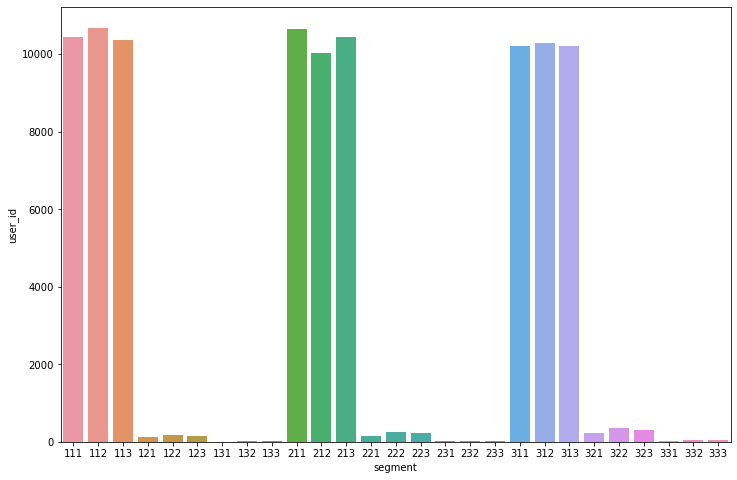

In [72]:
plt.figure(figsize = (12, 8))
sns.barplot(x=segments.segment, y=segments.user_id)

Как видно, сегменты получились очень разные по количеству пользователей в них. Причем, как и ожидалось, абсолютное большинство попало в кластер 1 метрики frequency - они сделали всего один заказ.

Рассчитаем средние значения для метрик по каждому из кластеров. 

Метрика ***recency*** - это количество дней, прошедших с последней покупки данного пользователя. Соответственно, в кластере 1 будут те пользователи, которые совершили покупку максимально давно, в кластере 2 - не так давно, в кластере 3 - совсем недавно. Наш датасет имеет примерно равномерное распределение по датам покупок, поэтому есть смысл разбить на кластеры примерно на равные промежутки времени.

Для расчета среднего для метрики ***recency*** предположим, что сегодня - последняя дата из датасета (2018-09-04) (чтобы не прибавлять лишние дни к каждому из кластеров). Тогда добавим новый столбец timedelta, в котором посчитаем, сколько дней прошло с момента последней покупки

In [73]:
from datetime import datetime

In [74]:
# Зададим сегодняшнее число
now = datetime(2018, 9, 4)

In [75]:
# Для объединение датасетов необходимо поменять название одной из колонок
orders_2 = full_df.rename(columns={'customer_unique_id': 'user_id'})

In [76]:
# Соедим датасет с входными данными и датасет с разбиением на кластеры
result = orders_2.merge(mapping, on='user_id')
result.head()

,user_id,order_id,order_purchase_timestamp,product_id,year,month,day_in_month,mean_weeks,frequency,monetary,recency,segment
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,a9516a079e37a9c9c36b9b78b10169e8,2017,May,31,4.428571,1,3,1,113
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,4aa6014eceb682077f9dc4bffebc05b0,2018,January,31,4.428571,1,3,2,213
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,bd07b66896d6f1494f5b86251848ced7,2018,May,31,4.428571,1,3,3,313
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,a5647c44af977b148e0a3a4751a09e2e,2018,March,31,4.428571,1,3,2,213
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,9391a573abe00141c56e38d84d7d5b3b,2018,July,31,4.428571,1,3,3,313


In [77]:
# Сгруппируем данные по покупателям, оставляя только последние даты покупки
recency = result.groupby('user_id', as_index=False) \
                .agg({'order_purchase_timestamp': 'max', 'recency': 'max'}) \
                .sort_values('order_purchase_timestamp')
recency.sort_values('order_purchase_timestamp').tail()

,user_id,order_purchase_timestamp,recency
34576,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,3
47802,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,3
68312,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,3
13741,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,3
95083,ff22e30958c13ffe219db7d711e8f564,2018-09-03 09:06:57,3


In [78]:
# Добавим столбец с количеством дней, прошедших со времени последней покупки до сегодняшнего дня
recency['timedelta'] = now - recency.order_purchase_timestamp
recency['timedelta'] = recency['timedelta'].astype(str).apply(lambda x: x.split(' ')[0])
recency

,user_id,order_purchase_timestamp,recency,timedelta
68611,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,1,729
27050,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,1,728
48972,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,1,718
5480,0eb1ee9dba87f5b36b4613a65074337c,2016-10-02 22:07:52,1,701
17750,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,1,700
...,...,...,...,...
34576,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,3,5
47802,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,3,5
68312,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,3,5
13741,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,3,5


Теперь выберем данные для каждого из трех кластеров:

In [79]:
recency.timedelta = recency.timedelta.astype(int)

In [80]:
recency1_mean = recency.query('recency == "1"').timedelta.mean()
recency1_mean

423.53132526352005

In [81]:
recency2_mean = recency.query('recency == "2"').timedelta.mean()
recency2_mean

224.8360408009067

In [82]:
recency3_mean = recency.query('recency == "3"').timedelta.mean()
recency3_mean

80.55856083320182

**Таким образом, получили, что:**
- **среднее значение recency для кластера 1 - 423.5 дня**
- **среднее значение recency для кластера 2 - 224.8 дней**
- **среднее значение recency для кластера 3 - 80.6 дней**

Теперь рассмотрим метрику ***frequency***

Метрика frequency нужна нам для того, чтобы понять, как часто пользователь что-то покупает. Поэтому чтобы посчитать среднее значение для каждого кластера, нам нужно выяснить, сколько покупок сделали пользователи в каждом из кластеров.

In [83]:
frequency = df.merge(mapping, on='user_id')

In [84]:
# сгруппируем по пользователям с подсчетом числа заказов
result_fr = frequency \
            .groupby('user_id', as_index=False) \
            .agg({'order_date': 'count', 'frequency': 'max'}) \
            .rename(columns={'order_date': 'number_of_orders'})
result_fr.head()

,user_id,number_of_orders,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1
2,0000f46a3911fa3c0805444483337064,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,1
4,0004aac84e0df4da2b147fca70cf8255,1,1


In [85]:
frequency1_mean = result_fr.query('frequency == "1"').number_of_orders.mean()
frequency1_mean

1.148368779128944

In [86]:
frequency2_mean = result_fr.query('frequency == "2"').number_of_orders.mean()
frequency2_mean

2.461338868707836

In [87]:
frequency3_mean = result_fr.query('frequency == "3"').number_of_orders.mean()
frequency3_mean

4.582278481012659

**Таким образом, получили, что:**
- **среднее значение frequency для кластера 1 - 1.15**
- **среднее значение frequency для кластера 2 - 2.46**
- **среднее значение frequency для кластера 3 - 4.58**

Теперь рассмотрим третью метрику, ***monetary***

Нам нужно выяснить, сколько денег потратил каждый из пользователей. Для этого сгруппируем данные по пользователям и посчитаем потраченную сумму. С учетом принадлежности к каждому из кластеров выведем среднее.

In [88]:
monetary = df.merge(mapping, on='user_id')

In [89]:
result_mon = monetary \
                .groupby('user_id', as_index=False) \
                .agg({'order_value': 'sum', 'monetary': 'max'})
result_mon.head()

,user_id,order_value,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1
2,0000f46a3911fa3c0805444483337064,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,3


In [90]:
monetary1_mean = result_mon.query('monetary == "1"').order_value.mean()
monetary1_mean

35.38269590900667

In [91]:
monetary2_mean = result_mon.query('monetary == "2"').order_value.mean()
monetary2_mean

90.72448157802786

In [179]:
monetary3_mean = result_mon.query('monetary == "3"').order_value.mean()
monetary3_mean

301.5763044368171

**Таким образом, получили, что:**
- **среднее значение monetary для кластера 1 - 35.38**
- **среднее значение monetary для кластера 2 - 90.72**
- **среднее значение monetary для кластера 3 - 301.58**